In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from PSSimPy.simulator import BasicSim, ABMSim
from PSSimPy.constraint_handler import MinBalanceConstraintHandler
from PSSimPy.queues import FIFOQueue
from PSSimPy.credit_facilities import SimplePriced
from PSSimPy.transaction_fee import FixedTransactionFee

In [2]:
import os
for file in os.listdir():
    if file.endswith(".csv"):
        os.remove(file)

# Simulation Run

In [3]:
NUM_DAYS = 15
OPEN_TIME = '08:00'
CLOSE_TIME = '12:00'

# BANK_FAILURE =  {1:[('09:00', 'b1')]}
BANK_FAILURE =  {5:[('09:00', 'b1')], 13: [('11:00', 'b5')]}

In [4]:
from transaction_generator import *
banks, accounts, transactions = generate_random_transactions(num_days=NUM_DAYS,
                                                             open_time=OPEN_TIME,
                                                             close_time=CLOSE_TIME,
                                                             max_txn_value=100,
                                                             seed=1234)

In [5]:
# banks = {'name': ['b1', 'b2', 'b3'], 'bank_code': ['Bank 1', 'Bank 2', 'Bank 3']}
# accounts = {'id': ['acc1', 'acc2', 'acc3'], 'owner': ['b1', 'b2', 'b3'], 'balance': [30, 20, 20]}
# transactions = {'sender_account': ['acc1', 'acc2', 'acc3', 'acc3', 'acc1', 'acc2', 'acc3', 'acc2', 'acc3', 'acc1'],
#                 'receipient_account': ['acc2', 'acc3', 'acc1', 'acc1', 'acc2', 'acc3', 'acc2', 'acc1', 'acc2', 'acc3'],
#                 'amount': [10, 20, 10, 20, 10, 20, 10, 20, 10, 20],
#                 'time': ['08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:30', '09:45', '09:45']}

In [6]:
sim_normal_cond = BasicSim(name = 'sim-normal',
                           banks = banks,
                           accounts = accounts,
                           transactions = transactions,
                           num_days=NUM_DAYS,
                           open_time = OPEN_TIME,
                           close_time = CLOSE_TIME,
                           constraint_handler = MinBalanceConstraintHandler(0),
                           queue = FIFOQueue(),
                           credit_facility = SimplePriced(),
                           transaction_fee_handler = FixedTransactionFee())

sim_normal_cond.run()

In [7]:
sim_stress_cond = BasicSim(name = 'sim-stress',
                           banks = banks,
                           accounts = accounts,
                           transactions = transactions,
                           num_days=NUM_DAYS,
                           open_time = OPEN_TIME,
                           close_time = CLOSE_TIME,
                           bank_failure = BANK_FAILURE,
                           constraint_handler = MinBalanceConstraintHandler(0),
                           queue = FIFOQueue(),
                           credit_facility = SimplePriced(),
                           transaction_fee_handler = FixedTransactionFee())

sim_stress_cond.run()

# Analysis

### Transactions

In [8]:
tran_normal = pd.read_csv('sim-normal-processed_transactions.csv')
tran_stress = pd.read_csv('sim-stress-processed_transactions.csv')

In [9]:
tran_normal

,day,time,from_account,to_account,amount,status
0,1,08:00,acc1,acc2,98,Success
1,1,08:00,acc5,acc3,82,Success
2,1,08:00,acc3,acc5,44,Success
3,1,08:00,acc2,acc1,71,Success
4,1,08:00,acc4,acc1,72,Success
...,...,...,...,...,...,...
2119,15,11:30,acc1,acc2,86,Success
2120,15,11:45,acc2,acc3,10,Success
2121,15,11:45,acc5,acc3,56,Success
2122,15,11:45,acc1,acc4,63,Success


In [10]:
tran_stress

,day,time,from_account,to_account,amount,status
0,1,08:00,acc4,acc3,69,Success
1,1,08:00,acc5,acc4,29,Success
2,1,08:00,acc5,acc4,43,Success
3,1,08:00,acc1,acc2,98,Success
4,1,08:00,acc2,acc1,71,Success
...,...,...,...,...,...,...
2119,15,11:30,acc5,acc3,78,Failed
2120,15,11:45,acc5,acc3,96,Failed
2121,15,11:45,acc2,acc3,10,Success
2122,15,11:45,acc5,acc3,56,Failed


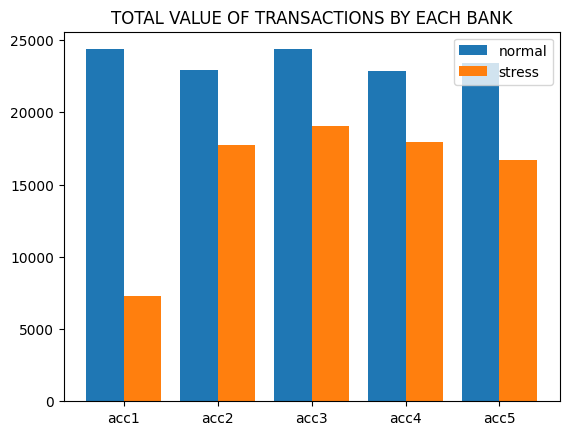

In [11]:
txn_value_normal = tran_normal[tran_normal['status'] == 'Success'].groupby('to_account')['amount'].sum()
txn_value_stress = tran_stress[tran_stress['status'] == 'Success'].groupby('to_account')['amount'].sum()

index = np.arange(len(txn_value_normal))
bar_width = 0.4

plt.bar(index, txn_value_normal, bar_width, label='normal')
plt.bar(index + bar_width, txn_value_stress, bar_width, label='stress')
plt.xticks(index + bar_width / 2, txn_value_normal.index)
plt.title('TOTAL VALUE OF TRANSACTIONS BY EACH BANK')
plt.legend()
plt.show()

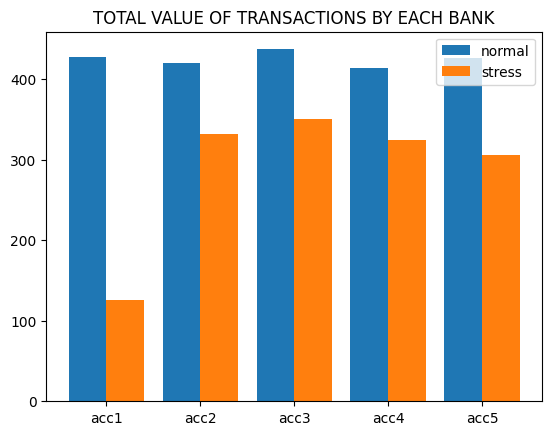

In [12]:
txn_volume_normal = tran_normal[tran_normal['status'] == 'Success'].groupby('to_account')['amount'].count()
txn_volume_stress = tran_stress[tran_stress['status'] == 'Success'].groupby('to_account')['amount'].count()

index = np.arange(len(txn_volume_normal))
bar_width = 0.4

plt.bar(index, txn_volume_normal, bar_width, label='normal')
plt.bar(index + bar_width, txn_volume_stress, bar_width, label='stress')
plt.xticks(index + bar_width / 2, txn_volume_normal.index)
plt.title('TOTAL VALUE OF TRANSACTIONS BY EACH BANK')
plt.legend()
plt.show()

In [13]:
first_fail_index = (tran_stress['status'] == 'Failed').idxmax()
tran_stress.iloc[first_fail_index:].head(5)

,day,time,from_account,to_account,amount,status
629,5,09:00,acc1,acc4,44,Failed
630,5,09:00,acc3,acc2,57,Success
631,5,09:00,acc1,acc2,73,Failed
632,5,09:00,acc2,acc4,81,Success
633,5,09:15,acc5,acc1,77,Failed


### Balance

In [14]:
import re

blnc_normal = pd.read_csv('sim-normal-account_balance.csv')
blnc_normal = blnc_normal.pivot(index=['day', 'time'], columns=['account'], values=['balance'])
blnc_normal.columns = blnc_normal.columns.to_flat_index().str.join('_')
blnc_normal.columns = blnc_normal.columns.map(lambda c: re.sub('_$', '', c))
blnc_normal = blnc_normal.reset_index()
blnc_normal

,day,time,balance_acc1,balance_acc2,balance_acc3,balance_acc4,balance_acc5
0,1,08:00,254.0,179.0,273.0,203.0,44.0
1,1,08:15,93.0,475.0,324.0,38.0,71.0
2,1,08:30,0.0,383.0,584.0,32.0,111.0
3,1,08:45,177.0,474.0,660.0,171.0,202.0
4,1,09:00,16.0,470.0,666.0,398.0,134.0
...,...,...,...,...,...,...,...
235,15,10:45,1671.0,1037.0,1465.0,1020.0,1119.0
236,15,11:00,1661.0,975.0,1559.0,998.0,1119.0
237,15,11:15,1661.0,872.0,1484.0,916.0,1379.0
238,15,11:30,1681.0,791.0,1588.0,951.0,1301.0


In [15]:
blnc_stress = pd.read_csv('sim-stress-account_balance.csv')
blnc_stress = blnc_stress.pivot(index=['day', 'time'], columns=['account'], values=['balance'])
blnc_stress.columns = blnc_stress.columns.to_flat_index().str.join('_')
blnc_stress.columns = blnc_stress.columns.map(lambda c: re.sub('_$', '', c))
blnc_stress = blnc_stress.reset_index()

# replace balance of failed banks into 0
blnc_stress.loc[(blnc_stress['day']>=1) & (blnc_stress['time']>='09:00'), 'balance_acc1'] = 0

blnc_stress

,day,time,balance_acc1,balance_acc2,balance_acc3,balance_acc4,balance_acc5
0,1,08:00,254.0,179.0,273.0,203.0,44.0
1,1,08:15,93.0,475.0,324.0,38.0,71.0
2,1,08:30,0.0,383.0,584.0,32.0,111.0
3,1,08:45,177.0,474.0,660.0,171.0,202.0
4,1,09:00,0.0,470.0,666.0,398.0,134.0
...,...,...,...,...,...,...,...
235,15,10:45,0.0,407.0,1507.0,640.0,1604.0
236,15,11:00,0.0,429.0,1507.0,618.0,1604.0
237,15,11:15,0.0,459.0,1495.0,600.0,1604.0
238,15,11:30,0.0,292.0,1616.0,646.0,1604.0


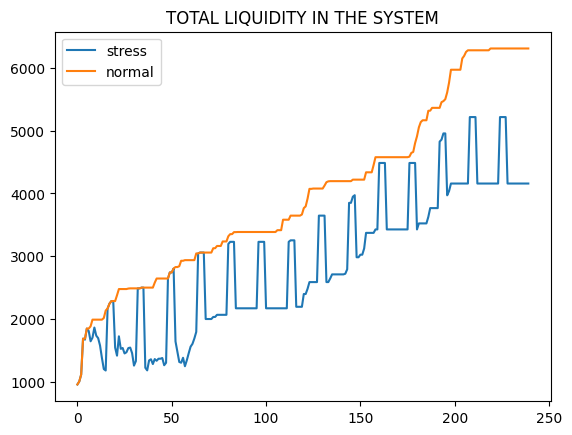

In [16]:
total_liquidity_stress = blnc_stress.loc[:, blnc_stress.columns.difference(['day', 'time'])].sum(axis=1)
total_liquidity_normal = blnc_normal.loc[:, blnc_normal.columns.difference(['day', 'time'])].sum(axis=1)

plt.plot(total_liquidity_stress, label='stress')
plt.plot(total_liquidity_normal, label='normal')
plt.title('TOTAL LIQUIDITY IN THE SYSTEM')
plt.legend()
plt.show()

### Credit Facility

In [17]:
cred_normal = pd.read_csv('sim-normal-credit_facility.csv')
cred_stress = pd.read_csv('sim-stress-credit_facility.csv')

cred_stress = cred_stress.pivot(index=['day', 'time'], columns=['account'], values=['total_credit'])
cred_normal = cred_normal.pivot(index=['day', 'time'], columns=['account'], values=['total_credit'])

cred_normal = cred_normal.reset_index()
cred_stress = cred_stress.reset_index()

In [18]:
cred_normal

day   time total_credit                              
account                    acc1    acc2   acc3    acc4   acc5
0         1  08:00          0.0     0.0    0.0     0.0   37.0
1         1  08:15         32.0     0.0    0.0     0.0   53.0
2         1  08:30         76.0     0.0    0.0    32.0   86.0
3         1  08:45        230.0     0.0    0.0   310.0  228.0
4         1  09:00        230.0     0.0    0.0   310.0  228.0
..       ..    ...          ...     ...    ...     ...    ...
235      15  10:45        328.0  1648.0  453.0  2108.0  859.0
236      15  11:00        328.0  1648.0  453.0  2108.0  859.0
237      15  11:15        328.0  1648.0  453.0  2108.0  859.0
238      15  11:30        328.0  1648.0  453.0  2108.0  859.0
239      15  11:45        328.0  1648.0  453.0  2108.0  859.0

[240 rows x 7 columns]

In [19]:
cred_stress

day   time total_credit                              
account                    acc1    acc2   acc3    acc4   acc5
0         1  08:00          0.0     0.0    0.0     0.0   37.0
1         1  08:15         32.0     0.0    0.0     0.0   53.0
2         1  08:30         76.0     0.0    0.0    32.0   86.0
3         1  08:45        230.0     0.0    0.0   310.0  228.0
4         1  09:00        230.0     0.0    0.0   310.0  228.0
..       ..    ...          ...     ...    ...     ...    ...
235      15  10:45        328.0  1137.0  421.0  1559.0  857.0
236      15  11:00        328.0  1137.0  421.0  1559.0  857.0
237      15  11:15        328.0  1137.0  421.0  1559.0  857.0
238      15  11:30        328.0  1137.0  421.0  1559.0  857.0
239      15  11:45        328.0  1137.0  421.0  1559.0  857.0

[240 rows x 7 columns]

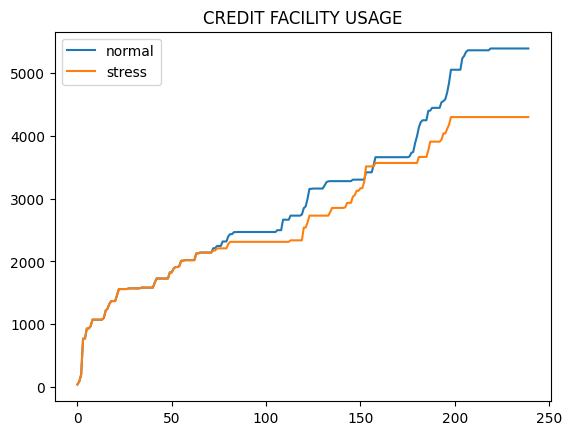

In [20]:
plt.plot(cred_normal['total_credit'].sum(axis=1), label='normal')
plt.plot(cred_stress['total_credit'].sum(axis=1), label='stress')
plt.title('CREDIT FACILITY USAGE')
plt.legend()
plt.show()

In [21]:
# find first index of failed bank
cred_stress.loc[(cred_stress['day'] >= 5) & (cred_stress['time'] >= '09:00'), :]

day   time total_credit                              
account                    acc1    acc2   acc3    acc4   acc5
68        5  09:00        328.0    11.0  421.0   558.0  823.0
69        5  09:15        328.0    11.0  421.0   558.0  823.0
70        5  09:30        328.0    11.0  421.0   558.0  823.0
71        5  09:45        328.0    11.0  421.0   558.0  823.0
72        5  10:00        328.0    44.0  421.0   558.0  823.0
..       ..    ...          ...     ...    ...     ...    ...
235      15  10:45        328.0  1137.0  421.0  1559.0  857.0
236      15  11:00        328.0  1137.0  421.0  1559.0  857.0
237      15  11:15        328.0  1137.0  421.0  1559.0  857.0
238      15  11:30        328.0  1137.0  421.0  1559.0  857.0
239      15  11:45        328.0  1137.0  421.0  1559.0  857.0

[132 rows x 7 columns]